# Fit Demo - Simulated Data with X-rays (in flux mode, no absorption)
---------------------------------------------------------------------

Simulate and fit:
- A normal galaxy with an X-ray model
- An AGN with an X-ray model

## Imports

In [1]:
import numpy as np
import astropy.units as u
from astropy.table import Table
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior

## Normal Galaxy
----------------

## Initialize Lightning

In [2]:
filter_labels = ['XRAY_2.0_7.0_keV', 'XRAY_1.2_2.0_keV', 'XRAY_0.5_1.2_keV',
                 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z',
                 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4',
                 'PACS_green', 'PACS_red']

redshift = 0.0
lum_dist = 10.0

arf = Table.read('/Users/Erik/Documents/Research/lightning/GOODS_AGN/data/xray_spectra_GOODSN/arfs/cdfn_near_aimpoint.arf')

l = Lightning(filter_labels,
             redshift=redshift, 
             lum_dist=lum_dist,
             flux_obs=None, 
             flux_obs_unc=None,
             wave_grid=(1e-1, 1e3, 1200),
             SFH_type='Piecewise-Constant',
             atten_type='Calzetti',
             dust_emission=True,
             agn_emission=False,
             xray_stellar_emission='Stellar-Plaw',
             xray_agn_emission=None,
             xray_absorption=None,
             xray_wave_grid=(1e-6, 1e-1, 200),
             xray_arf=arf,
             xray_exposure=1e6,
             xray_mode='flux',
             print_setup_time=True,
             model_unc=0.10
             )

# Redshift 0, default stellar age bins
# l = Lightning(filter_labels, 
#               redshift=0.0,
#               SFH_type='Piecewise-Constant',
#               atten_type='Modified-Calzetti',
#               dust_emission=True,
#               print_setup_time=True)

/Users/Erik/Documents/Research/lightning/plightning/lightning/get_filters.py:140: RuntimeWarning: invalid value encountered in true_divide
  transm_norm_interp = transm_interp / trapz(transm_interp, wave_grid)


0.046 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
0.557 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
1.778 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.025 s elapsed in X-ray model setup
2.408 s elapsed total


In [3]:
l.print_params(verbose=True)


Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5

Calzetti
     Parameter  Lo  Hi                      Description
-------------- --- --- --------------------------------
calz_tauV_diff 0.0 inf Optical depth of the diffuse ISM

DL07-Dust
      Parameter     Lo       Hi                                                             Description
--------------- ------ -------- -----------------------------------------------------------------------
dl07_dust_alpha  -10.0      4.0                  Radiation field intensity distribution power law index
dl07_dust_U_min    0.1     25.0                                       Radiation field minimum intensity
dl07_dust_U_max 1000.0 300000.0                                       Radi

## Fake some data

In [3]:
params = np.array([5,5,1,1,1,
                   0.3,
                   2, 1, 3e5, 0.1, 0.01,
                   1.8])

Lmod, _ = l.get_model_lnu(params)
Lmod_xray, _ = l.get_xray_model_lnu(params)

# By (weird) construction, the elements of Lmod corresponding to the X-ray filters
# in Lmod are NaN, and the elements of Lmod_xray corresponding to the UV-IR filters
# are NaN.
xray_mask = np.isnan(Lmod)
Lmod[xray_mask] = Lmod_xray[xray_mask]

snr = 10.0

rng = np.random.default_rng()

Lsim = rng.normal(loc=Lmod, scale=Lmod / snr)
Lsim_unc = Lsim / snr

# A silly step, converting the data to mJy just so lightning can convert back to Lsun Hz-1
# Note that the input units for the X-ray fluxes are also mJy; this is kind of weird since
# X-ray fluxes are typically not presented as monochromatic given the width of the bandpasses
# involved.
DL = 10 * u.Mpc

fsim = (Lsim * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value
fsim_unc = (Lsim_unc  * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value

# Note the warning generated by this step -- the minimum luminosity distance is probably something
# we ought to change; we'll want to add the option to specify a luminosity distance rather than
# a redshift for very nearby galaxies.
l.flux_obs = fsim
l.flux_unc = fsim_unc

print(fsim)
print(fsim_unc)

[7.36722196e-05 7.92700626e-05 1.93333254e-04 3.07860514e+02
 4.78962138e+02 6.14008652e+02 5.73370727e+02 8.65492722e+02
 4.62680284e+02 2.76606509e+02 4.87727080e+02 1.23140531e+03
 1.16331438e+05 1.41783330e+05]
[7.36722196e-06 7.92700626e-06 1.93333254e-05 3.07860514e+01
 4.78962138e+01 6.14008652e+01 5.73370727e+01 8.65492722e+01
 4.62680284e+01 2.76606509e+01 4.87727080e+01 1.23140531e+02
 1.16331438e+04 1.41783330e+04]


## Fit with `emcee`

In [4]:
p = np.array([5,5,1,1,1,
              0.3,
              2, 1, 3e5, 0.1, 0.01,
              1.8])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant
const_dim = np.array([False, False, False, False, False,
                      False,
                      True, False, True, False, False,
                      False])

var_dim = ~const_dim

priors = [UniformPrior([0, 1e1]), # SFH
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 3]), # tauV
          None, # alpha
          UniformPrior([0.1, 25]), # Umin
          None, # Umax
          UniformPrior([0,1]),
          UniformPrior([0.0047, 0.0458]),
          UniformPrior([0,3])]

# Starting the MCMC in a very small Gaussian ball around the 'true' parameters
p0 = p[None, :] + rng.normal(loc=0, scale=1e-3, size=(75, len(p)))
p0[:, const_dim] = p[const_dim]

In [5]:
# Will print a tqdm progress bar -- note that the pure models s-1 throughput
# is the number of iterations s-1 that it shows multiplied by the number of walkers.
mcmc = l.fit(p0, method='emcee', Nwalkers=75, Nsteps=5000, priors=priors, const_dim=const_dim)

[3.84471402 3.83032995 3.86361464 3.85820741 3.81022041]
[3.85094781 3.83390683 3.88689114 3.81327988 3.85781249]
[3.85739641 3.83354416 3.86031592 3.83633091 3.85838818]
[3.84847575 3.85744761 3.85942069 3.83926671 3.83066296]
[3.85353608 3.88246991 3.80348608 3.89485731 3.83934363]
[3.85766065 3.85895693 3.90299523 3.75490362 3.82272097]
[3.84914157 3.93543939 3.84438845 3.82181586 3.81326108]
[3.87213682 3.86362036 3.91659455 3.69891744 3.77576661]
[3.87108653 3.94672519 3.7957841  3.84773822 3.82557791]
[3.85416316 3.84593189 3.90836128 3.69724116 3.88764354]
[3.86678907 3.95859637 3.78916058 3.79751286 3.84333815]
[3.85742307 4.075313   3.85975402 3.80370031 3.8051937 ]
[3.81188501 3.82910118 3.94484969 3.85358508 3.84724318]
[3.92546334 3.75869591 3.75685132 3.92990545 3.86131978]
[3.78677687 3.86646072 3.74953245 3.72921693 3.89586073]
[3.86579614 3.86067142 3.74889574 3.62507671 3.92602378]
[3.73511457 3.76126907 4.21669818 3.40355208 3.85853784]
[3.78012898 3.70086672 3.732242

In [6]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
chain = mcmc.get_chain(discard=1000, thin=300, flat=True)
logprob_chain = mcmc.get_log_prob(discard=1000, thin=300, flat=True)

MCMC mean acceptance fraction: 0.262


### SFH chain plot

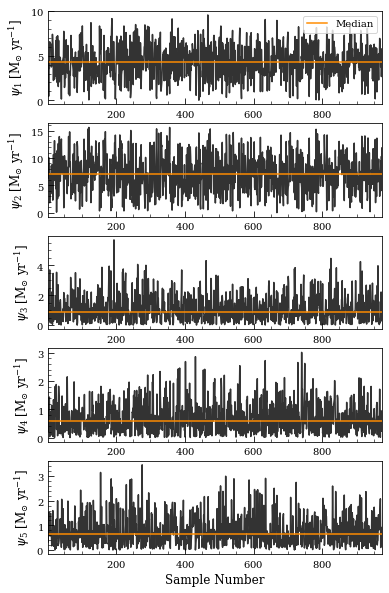

In [7]:
fig, axs = plt.subplots(5,1, figsize=(6,10))

t = np.arange(len(chain[:,0])) + 1
for i in np.arange(5):
    axs[i].plot(t, chain[:,i], color='k', alpha=0.8)
    axs[i].axhline(np.median(chain[:,i]), color='darkorange', label='Median')
    #axs[i].axhline(1, color='dodgerblue', label='Truth')
    axs[i].set_ylabel(r'$\psi_%d\ [\rm M_{\odot}\ yr^{-1}]$' % (i + 1))
    axs[i].set_xlim(1,t[-1])
    #axs[i].set_yscale('log')

axs[4].set_xlabel('Sample Number')

axs[0].legend(loc='upper right', frameon=True)

### Corner plot

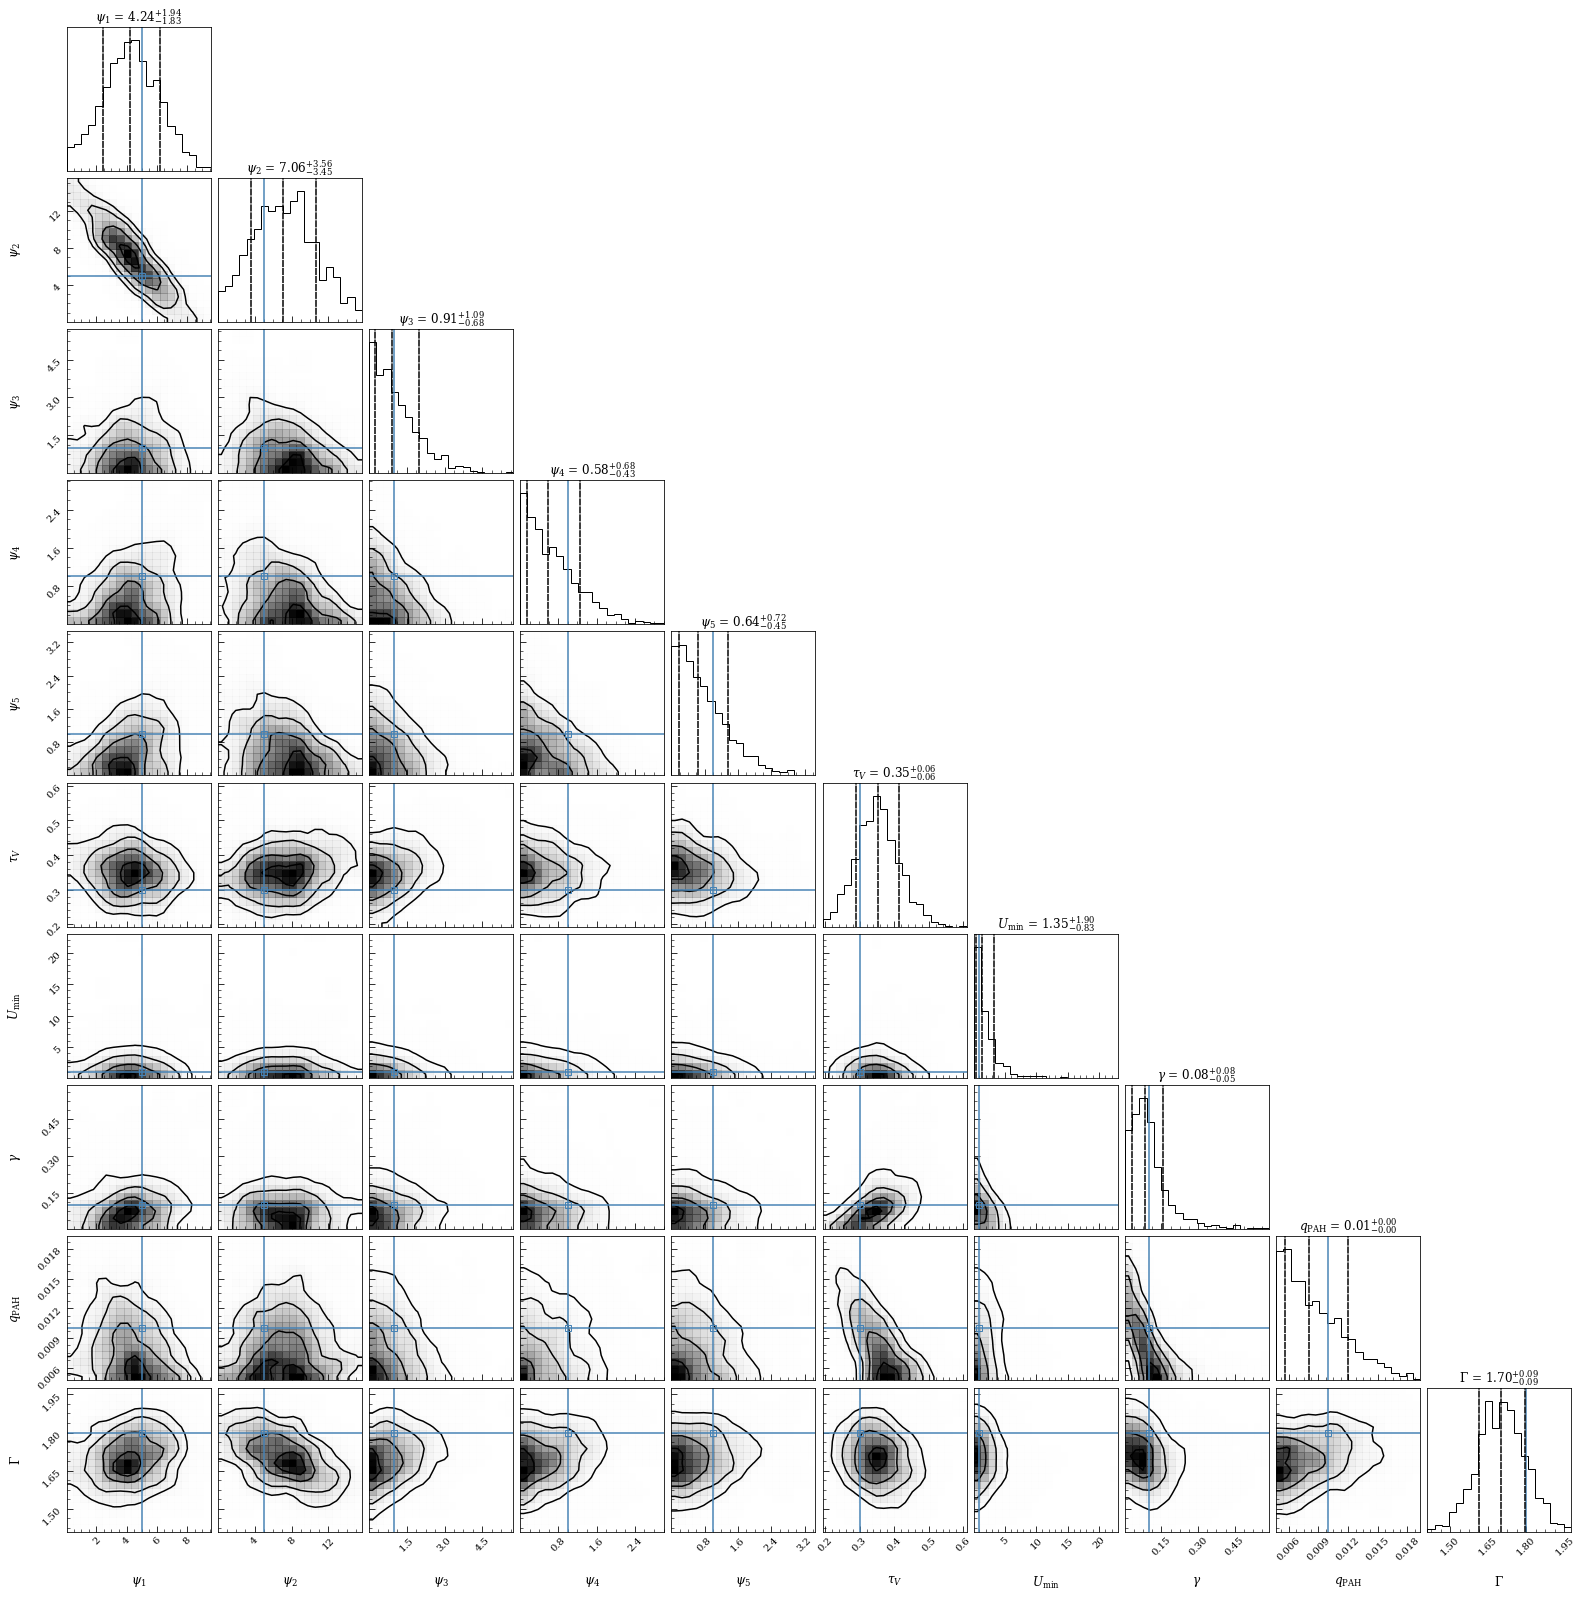

In [8]:
labels = [r'$\psi_1$', r'$\psi_2$', r'$\psi_3$', r'$\psi_4$', r'$\psi_5$',
          r'$\tau_V$', r'$U_{\rm min}$', r'$\gamma$', r'$q_{\rm PAH}$', r'$\Gamma$']

# levels = np.array([0.68])
# levels_sigma = np.array([1,2,3])
# levels = 1 - np.exp(-0.5 * levels_sigma ** 2)
# print(levels)

fig = corner(chain,
             labels=labels,
             quantiles=(0.16, 0.50, 0.84),
             smooth=1,
             levels=None,
             truths=p[var_dim],
             show_titles=True)

### Single out $\Gamma$

Text(0.5, 0, 'Trial Number')

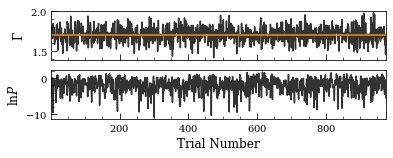

In [9]:
fig, ax = plt.subplots(2,1, figsize=(6,2))

t = np.arange(len(chain[:,0])) + 1

ax[0].plot(t, chain[:,-1], color='k', alpha=0.8)
ax[0].axhline(np.median(chain[:,-1]), color='darkorange', label='Median')
ax[0].set_ylabel(r'$\Gamma$')
ax[0].set_xlim(1,t[-1])
ax[0].set_xticklabels([])

ax[1].plot(t, logprob_chain, color='k', alpha=0.8)
ax[1].set_ylabel(r'$\ln P$')
ax[1].set_xlim(1,t[-1])

ax[1].set_xlabel('Trial Number')

## SED-SFH plot

In [10]:
# Get best-fitting SED
bestfit = np.argmax(logprob_chain)
bestfit_samples = chain[bestfit,:]
bestfit_params = p
bestfit_params[var_dim] = bestfit_samples

lnu_hires_best, lnu_hires_intr_best = l.get_model_lnu_hires(bestfit_params)
lnu_best, lnu_intr_best = l.get_model_lnu(bestfit_params)

lnu_xray_hires_best, lnu_xray_hires_intr_best = l.get_xray_model_lnu_hires(bestfit_params)
lnu_xray_best, lnu_xray_intr_best = l.get_xray_model_lnu(bestfit_params)


lnu_unc_total = np.sqrt(l.Lnu_unc**2 + (l.model_unc * lnu_best)**2)
lnu_xray_unc_total = np.sqrt(l.Lnu_unc**2 + (l.model_unc * lnu_xray_best)**2)

# Get the quantiles of the SFH
sfh_q = np.quantile(chain[:,:5], q=(0.16, 0.5, 0.84), axis=0)

(1000000.0, 13600000000.0)

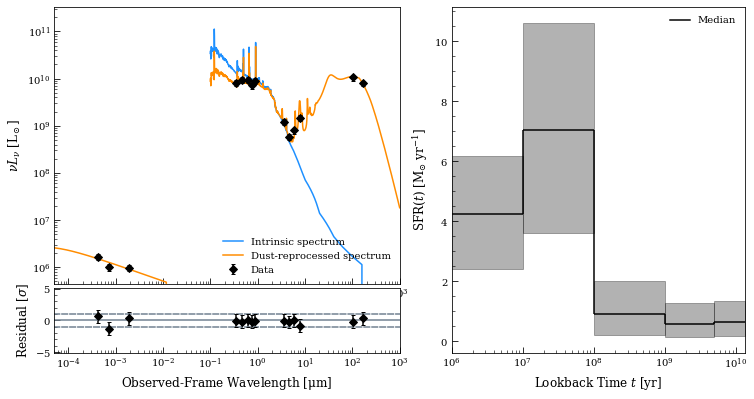

In [24]:
# fig, axs = plt.subplots(1,2, figsize=(12,6))
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes([0.1, 0.26, 0.4, 0.64])
ax2 = fig.add_axes([0.1, 0.1, 0.4, 0.15])
ax3 = fig.add_axes([0.56, 0.1, 0.34, 0.8])

ax1.plot(l.wave_grid_obs, l.nu_grid_obs * lnu_hires_intr_best,
            color='dodgerblue', label='Intrinsic spectrum')

ax1.plot(l.wave_grid_obs, l.nu_grid_obs * lnu_hires_best,
            color='darkorange', label='Dust-reprocessed spectrum')

ax1.errorbar(l.wave_obs, l.nu_obs * l.Lnu_obs, yerr=l.nu_obs * lnu_unc_total,
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='',
             label='Data')

ax1.plot(l.xray_stellar_em.wave_grid_obs,
         l.xray_stellar_em.nu_grid_obs * lnu_xray_hires_best,
         color='darkorange')
ax1.errorbar(l.xray_stellar_em.wave_obs,
             l.xray_stellar_em.nu_obs * l.Lnu_obs,
             yerr=l.xray_stellar_em.nu_obs * lnu_xray_unc_total,
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='')

#ax1.set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
ax1.set_ylabel(r'$\nu L_{\nu}\ [\rm L_\odot]$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(5e-5, 1e3)
ax1.set_ylim(0.9 * 5e5,)
ax1.legend(loc='lower right')

delchi = (l.Lnu_obs - lnu_best) / lnu_unc_total

ax2.axhline(0, color='slategray', linestyle='-')
ax2.axhline(-1, color='slategray', linestyle='--')
ax2.axhline(1, color='slategray', linestyle='--')

ax2.errorbar(l.wave_obs, delchi, yerr=(1 + np.zeros_like(delchi)),
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='')

delchi_xray = (l.Lnu_obs - lnu_xray_best) / lnu_xray_unc_total

ax2.errorbar(l.xray_stellar_em.wave_obs,
             delchi_xray,
             yerr=(1 + np.zeros_like(delchi)),
             marker='D',
             color='k',
             markerfacecolor='k',
             capsize=2,
             linestyle='')

ax2.set_xscale('log')
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(-5.1,5.1)

ax2.set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
ax2.set_ylabel(r'Residual $[\sigma]$')

# Making nice step plots remains an annoyance
#print(sfh_q.shape)
for i in np.arange(len(l.ages) - 1):
    ax3.fill_between([l.ages[i], l.ages[i+1]],
                        [sfh_q[0,i], sfh_q[0,i]], 
                        [sfh_q[2,i], sfh_q[2,i]],
                        color='k', alpha=0.3)
    l1 = ax3.hlines(sfh_q[1,i], l.ages[i], l.ages[i+1], color='k')
    if (i < len(l.ages) - 2): 
        ax3.vlines(l.ages[i+1], sfh_q[1,i], sfh_q[1,i+1], color='k')

ax3.legend([l1], ['Median'], loc='upper right')

ax3.set_xlabel(r'Lookback Time $t$ [yr]')
ax3.set_ylabel(r'${\rm SFR}(t)\ [\rm M_{\odot}\ yr^{-1}]$')
        
ax3.set_xscale('log')
ax3.set_xlim(1e6,13.6*10**9)

## AGN
------

## Initialize Lightning

In [2]:
filter_labels = ['XRAY_2.0_7.0_keV', 'XRAY_1.2_2.0_keV', 'XRAY_0.5_1.2_keV',
                 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z',
                 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4',
                 'PACS_green', 'PACS_red']

redshift = 0.0
lum_dist = 10.0

arf = Table.read('/Users/Erik/Documents/Research/lightning/GOODS_AGN/data/xray_spectra_GOODSN/arfs/cdfn_near_aimpoint.arf')

l = Lightning(filter_labels,
             redshift=redshift, 
             lum_dist=lum_dist,
             flux_obs=None, 
             flux_obs_unc=None,
             wave_grid=(1e-1, 1e3, 1200),
             SFH_type='Piecewise-Constant',
             atten_type='Calzetti',
             dust_emission=True,
             agn_emission=True,
             xray_stellar_emission='Stellar-Plaw',
             xray_agn_emission='AGN-Plaw',
             xray_absorption=None,
             xray_wave_grid=(1e-6, 1e-1, 200),
             xray_arf=arf,
             xray_exposure=1e6,
             xray_mode='flux',
             print_setup_time=True,
             model_unc=0.10
             )

/Users/Erik/Documents/Research/lightning/plightning/lightning/get_filters.py:140: RuntimeWarning: invalid value encountered in true_divide
  transm_norm_interp = transm_interp / trapz(transm_interp, wave_grid)


0.045 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
0.525 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
1.752 s elapsed in dust emission model setup
0.063 s elapsed in agn emission model setup
0.051 s elapsed in X-ray model setup
2.437 s elapsed total


In [3]:
l.print_params(verbose=True)


Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5

Calzetti
     Parameter  Lo  Hi                      Description
-------------- --- --- --------------------------------
calz_tauV_diff 0.0 inf Optical depth of the diffuse ISM

DL07-Dust
      Parameter     Lo       Hi                                                             Description
--------------- ------ -------- -----------------------------------------------------------------------
dl07_dust_alpha  -10.0      4.0                  Radiation field intensity distribution power law index
dl07_dust_U_min    0.1     25.0                                       Radiation field minimum intensity
dl07_dust_U_max 1000.0 300000.0                                       Radi

## Fake some data

In [4]:
params = np.array([5,5,1,1,1,
                   0.3,
                   2, 1, 3e5, 0.1, 0.01,
                   11.5, 0.5, 7,
                   1.8,
                   1.8, -0.2])

Lmod, _ = l.get_model_lnu(params)
Lmod_xray, _ = l.get_xray_model_lnu(params)

# By (weird) construction, the elements of Lmod corresponding to the X-ray filters
# in Lmod are NaN, and the elements of Lmod_xray corresponding to the UV-IR filters
# are NaN.
xray_mask = np.isnan(Lmod)
Lmod[xray_mask] = Lmod_xray[xray_mask]

snr = 10.0

rng = np.random.default_rng()

Lsim = rng.normal(loc=Lmod, scale=Lmod / snr)
Lsim_unc = Lsim / snr

# A silly step, converting the data to mJy just so lightning can convert back to Lsun Hz-1
# Note that the input units for the X-ray fluxes are also mJy; this is kind of weird since
# X-ray fluxes are typically not presented as monochromatic given the width of the bandpasses
# involved.
DL = 10 * u.Mpc

fsim = (Lsim * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value
fsim_unc = (Lsim_unc  * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value

# Note the warning generated by this step -- the minimum luminosity distance is probably something
# we ought to change; we'll want to add the option to specify a luminosity distance rather than
# a redshift for very nearby galaxies.
l.flux_obs = fsim
l.flux_unc = fsim_unc

print(fsim)
print(fsim_unc)

[1.37105842e-01 2.60269692e-01 6.13471393e-01 3.12617326e+02
 5.36647835e+02 7.18865188e+02 5.93858184e+02 7.42140460e+02
 3.58942264e+03 6.58950170e+03 1.23387380e+04 1.36881709e+04
 1.09997855e+05 1.20485377e+05]
[1.37105842e-02 2.60269692e-02 6.13471393e-02 3.12617326e+01
 5.36647835e+01 7.18865188e+01 5.93858184e+01 7.42140460e+01
 3.58942264e+02 6.58950170e+02 1.23387380e+03 1.36881709e+03
 1.09997855e+04 1.20485377e+04]


## Fit with `emcee`

In [6]:
p = np.array([5,5,1,1,1,
              0.3,
              2, 1, 3e5, 0.1, 0.01,
              11.5, 0.5, 7,
              1.8,
              1.8, -0.2])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant
const_dim = np.array([False, False, False, False, False,
                      False,
                      True, False, True, False, False,
                      False, True, True,
                      True,
                      False, False])

var_dim = ~const_dim

priors = [UniformPrior([0, 1e1]), # SFH
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 3]), # tauV
          None, # alpha
          UniformPrior([0.1, 25]), # Umin
          None, # Umax
          UniformPrior([0,1]), # Gamma
          UniformPrior([0.0047, 0.0458]), #qPAH
          UniformPrior([11.0, 12.0]), # log L_AGN
          None, # cos i
          None, # tau 9.7
          None, # stellar pop. pho. index
          UniformPrior([0,3]), # AGN pho. index
          UniformPrior([-0.4, 0.4]) # Deviation from LR17
          ]

# Starting the MCMC in a very small Gaussian ball around the 'true' parameters
p0 = p[None, :] + rng.normal(loc=0, scale=1e-3, size=(75, len(p)))
p0[:, const_dim] = p[const_dim]

In [7]:
# Will print a tqdm progress bar -- note that the pure models s-1 throughput
# is the number of iterations s-1 that it shows multiplied by the number of walkers.
mcmc = l.fit(p0, method='emcee', Nwalkers=75, Nsteps=5000, priors=priors, const_dim=const_dim)

100%|██████████| 5000/5000 [08:15<00:00, 10.09it/s]


In [8]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
chain = mcmc.get_chain(discard=1000, thin=300, flat=True)
logprob_chain = mcmc.get_log_prob(discard=1000, thin=300, flat=True)

MCMC mean acceptance fraction: 0.220


## SFH chain plot

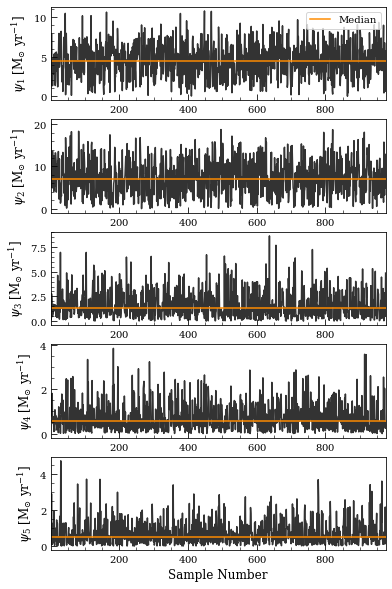

In [9]:
fig, axs = plt.subplots(5,1, figsize=(6,10))

t = np.arange(len(chain[:,0])) + 1
for i in np.arange(5):
    axs[i].plot(t, chain[:,i], color='k', alpha=0.8)
    axs[i].axhline(np.median(chain[:,i]), color='darkorange', label='Median')
    #axs[i].axhline(1, color='dodgerblue', label='Truth')
    axs[i].set_ylabel(r'$\psi_%d\ [\rm M_{\odot}\ yr^{-1}]$' % (i + 1))
    axs[i].set_xlim(1,t[-1])
    #axs[i].set_yscale('log')

axs[4].set_xlabel('Sample Number')

axs[0].legend(loc='upper right', frameon=True)

## Corner plot

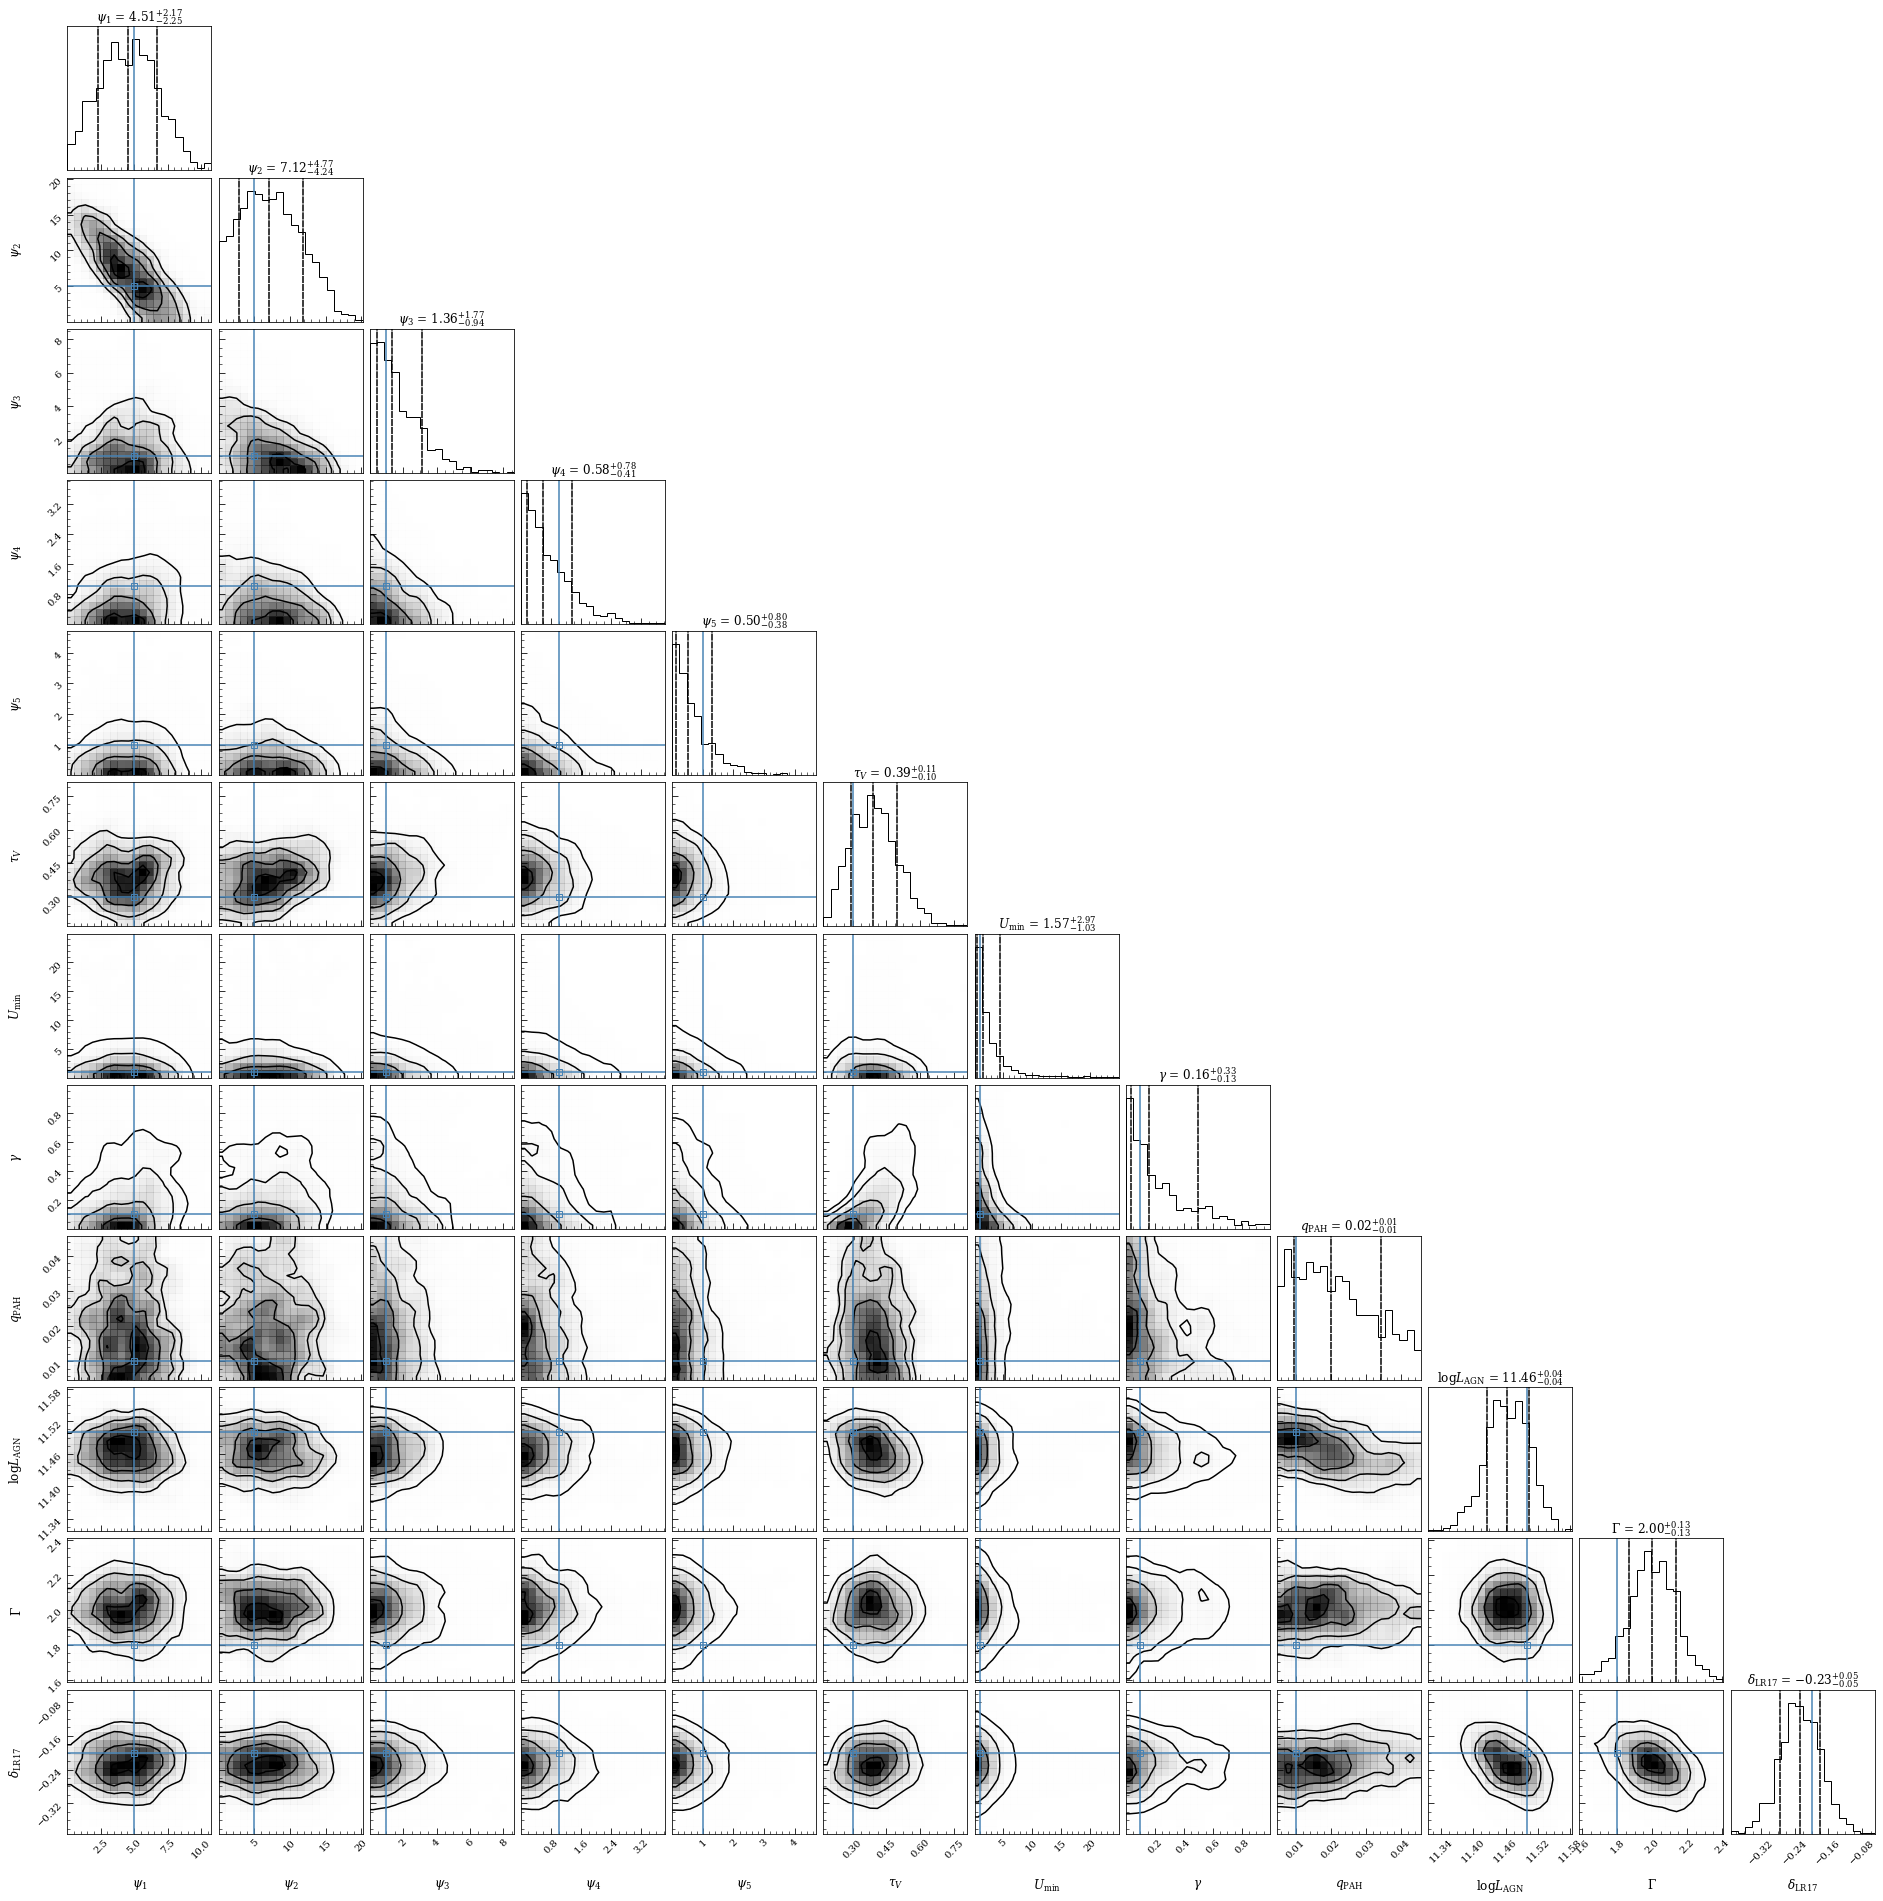

In [10]:
labels = [r'$\psi_1$', r'$\psi_2$', r'$\psi_3$', r'$\psi_4$', r'$\psi_5$',
          r'$\tau_V$', r'$U_{\rm min}$', r'$\gamma$', r'$q_{\rm PAH}$',
          r'$\log L_{\rm AGN}$', r'$\Gamma$', r'$\delta_{\rm LR17}$']

# levels = np.array([0.68])
# levels_sigma = np.array([1,2,3])
# levels = 1 - np.exp(-0.5 * levels_sigma ** 2)
# print(levels)

fig = corner(chain,
             labels=labels,
             quantiles=(0.16, 0.50, 0.84),
             smooth=1,
             levels=None,
             truths=p[var_dim],
             show_titles=True)

## SED-SFH plot

In [11]:
# Get best-fitting SED
bestfit = np.argmax(logprob_chain)
bestfit_samples = chain[bestfit,:]
bestfit_params = p
bestfit_params[var_dim] = bestfit_samples

lnu_hires_best, lnu_hires_intr_best = l.get_model_lnu_hires(bestfit_params)
lnu_best, lnu_intr_best = l.get_model_lnu(bestfit_params)

lnu_xray_hires_best, lnu_xray_hires_intr_best = l.get_xray_model_lnu_hires(bestfit_params)
lnu_xray_best, lnu_xray_intr_best = l.get_xray_model_lnu(bestfit_params)


lnu_unc_total = np.sqrt(l.Lnu_unc**2 + (l.model_unc * lnu_best)**2)
lnu_xray_unc_total = np.sqrt(l.Lnu_unc**2 + (l.model_unc * lnu_xray_best)**2)

# Get the quantiles of the SFH
sfh_q = np.quantile(chain[:,:5], q=(0.16, 0.5, 0.84), axis=0)

(1000000.0, 13600000000.0)

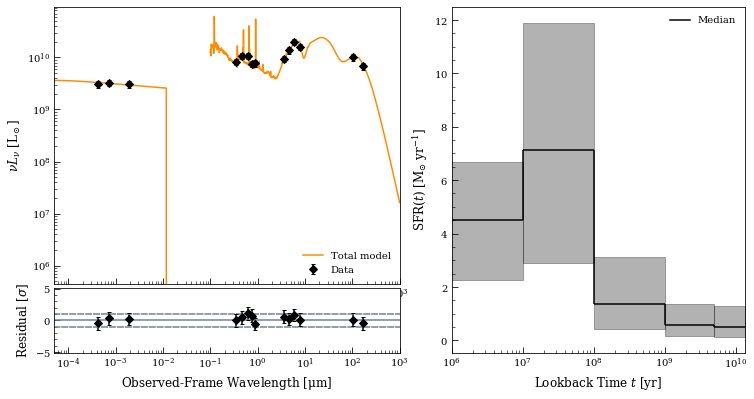

In [12]:
# fig, axs = plt.subplots(1,2, figsize=(12,6))
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes([0.1, 0.26, 0.4, 0.64])
ax2 = fig.add_axes([0.1, 0.1, 0.4, 0.15])
ax3 = fig.add_axes([0.56, 0.1, 0.34, 0.8])

# ax1.plot(l.wave_grid_obs, l.nu_grid_obs * lnu_hires_intr_best,
#             color='dodgerblue', label='Intrinsic spectrum')

ax1.plot(l.wave_grid_obs, l.nu_grid_obs * lnu_hires_best,
            color='darkorange', label='Total model')

ax1.errorbar(l.wave_obs, l.nu_obs * l.Lnu_obs, yerr=l.nu_obs * lnu_unc_total,
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='',
             label='Data')

ax1.plot(l.xray_stellar_em.wave_grid_obs,
         l.xray_stellar_em.nu_grid_obs * lnu_xray_hires_best,
         color='darkorange')
ax1.errorbar(l.xray_stellar_em.wave_obs,
             l.xray_stellar_em.nu_obs * l.Lnu_obs,
             yerr=l.xray_stellar_em.nu_obs * lnu_xray_unc_total,
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='')

#ax1.set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
ax1.set_ylabel(r'$\nu L_{\nu}\ [\rm L_\odot]$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(5e-5, 1e3)
ax1.set_ylim(0.9 * 5e5,)
ax1.legend(loc='lower right')

delchi = (l.Lnu_obs - lnu_best) / lnu_unc_total

ax2.axhline(0, color='slategray', linestyle='-')
ax2.axhline(-1, color='slategray', linestyle='--')
ax2.axhline(1, color='slategray', linestyle='--')

ax2.errorbar(l.wave_obs, delchi, yerr=(1 + np.zeros_like(delchi)),
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='')

delchi_xray = (l.Lnu_obs - lnu_xray_best) / lnu_xray_unc_total

ax2.errorbar(l.xray_stellar_em.wave_obs,
             delchi_xray,
             yerr=(1 + np.zeros_like(delchi)),
             marker='D',
             color='k',
             markerfacecolor='k',
             capsize=2,
             linestyle='')

ax2.set_xscale('log')
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(-5.1,5.1)

ax2.set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
ax2.set_ylabel(r'Residual $[\sigma]$')

# Making nice step plots remains an annoyance
#print(sfh_q.shape)
for i in np.arange(len(l.ages) - 1):
    ax3.fill_between([l.ages[i], l.ages[i+1]],
                        [sfh_q[0,i], sfh_q[0,i]], 
                        [sfh_q[2,i], sfh_q[2,i]],
                        color='k', alpha=0.3)
    l1 = ax3.hlines(sfh_q[1,i], l.ages[i], l.ages[i+1], color='k')
    if (i < len(l.ages) - 2): 
        ax3.vlines(l.ages[i+1], sfh_q[1,i], sfh_q[1,i+1], color='k')

ax3.legend([l1], ['Median'], loc='upper right')

ax3.set_xlabel(r'Lookback Time $t$ [yr]')
ax3.set_ylabel(r'${\rm SFR}(t)\ [\rm M_{\odot}\ yr^{-1}]$')
        
ax3.set_xscale('log')
ax3.set_xlim(1e6,13.6*10**9)